# Generalization

imports

In [52]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
from sklearn.decomposition import PCA

print("Libraries imported successfully.\n")
import warnings
warnings.filterwarnings('ignore')
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_and_import('statsmodels')
import statsmodels.api as sm


Libraries imported successfully.



In [53]:
test_df = pd.read_csv('test_data.csv')
print(f"Test data shape: {test_df.shape}\n")


Test data shape: (1012, 96)



# --- Save Index separately ---


In [54]:
test_index = test_df['Index'].copy()


# --- Drop Index column for processing ---


In [55]:
X_test_raw = test_df.drop(columns=['Index'])


# --- Preprocessing Step 1: Gaussian Transformation ---


In [56]:
print("Applying PowerTransformer (Yeo-Johnson) on test data...")
pt = PowerTransformer(method='yeo-johnson')
X_test_gauss = pd.DataFrame(pt.fit_transform(X_test_raw), columns=X_test_raw.columns)
print("Transformation applied.\n")

Applying PowerTransformer (Yeo-Johnson) on test data...
Transformation applied.



# --- Preprocessing Step 2: Winsorization ---


In [57]:
print("Applying winsorization on heavy-tailed features...")
# Identify heavy-tailed features
stats = X_test_gauss.agg(['mean', 'std', 'skew', 'kurt']).T
heavy_skew = stats.index[stats['skew'].abs() > 3]
heavy_kurt = stats.index[stats['kurt'].abs() > 30]
heavy_features = sorted(set(heavy_skew) | set(heavy_kurt))

def winsorize_series(s, p=0.01):
    return pd.Series(st.mstats.winsorize(s, limits=[p, p]), index=s.index)

X_test_wins = X_test_gauss.copy()
for col in heavy_features:
    X_test_wins[col] = winsorize_series(X_test_wins[col])

print("Winsorization completed.\n")


Applying winsorization on heavy-tailed features...
Winsorization completed.



# --- Preprocessing Step 3: Feature Selection ---


In [58]:
selected_features = [
' ROA(C) before interest and depreciation before interest',
       ' Research and development expense rate',
       ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets', ' Total expense/Assets',
       ' Operating Expense Rate', ' Long-term fund suitability ratio (A)',
       ' Current Asset Turnover Rate', ' Tax rate (A)',
       ' Revenue Per Share (Yuan ¥)', ' Inventory Turnover Rate (times)',
       ' Current Liabilities/Liability', ' Total Asset Growth Rate',
       ' Current Ratio', ' Revenue per person',
       ' Fixed Assets Turnover Frequency',
       ' Interest-bearing debt interest rate', ' Allocation rate per person',
       ' Total assets to GNP price', ' Contingent liabilities/Net worth',
       ' Total debt/Total net worth', ' Operating Gross Margin',
       ' Cash flow rate', ' Average Collection Days',
       ' Degree of Financial Leverage (DFL)', ' Accounts Receivable Turnover',
       ' Net Value Growth Rate', ' Realized Sales Gross Profit Growth Rate'
]




X_test_final = X_test_wins[selected_features]
print(f"Test data final shape after feature selection: {X_test_final.shape}\n")


Test data final shape after feature selection: (1012, 28)



# Correlation Heatmap 


Generating correlation heatmap of test data...


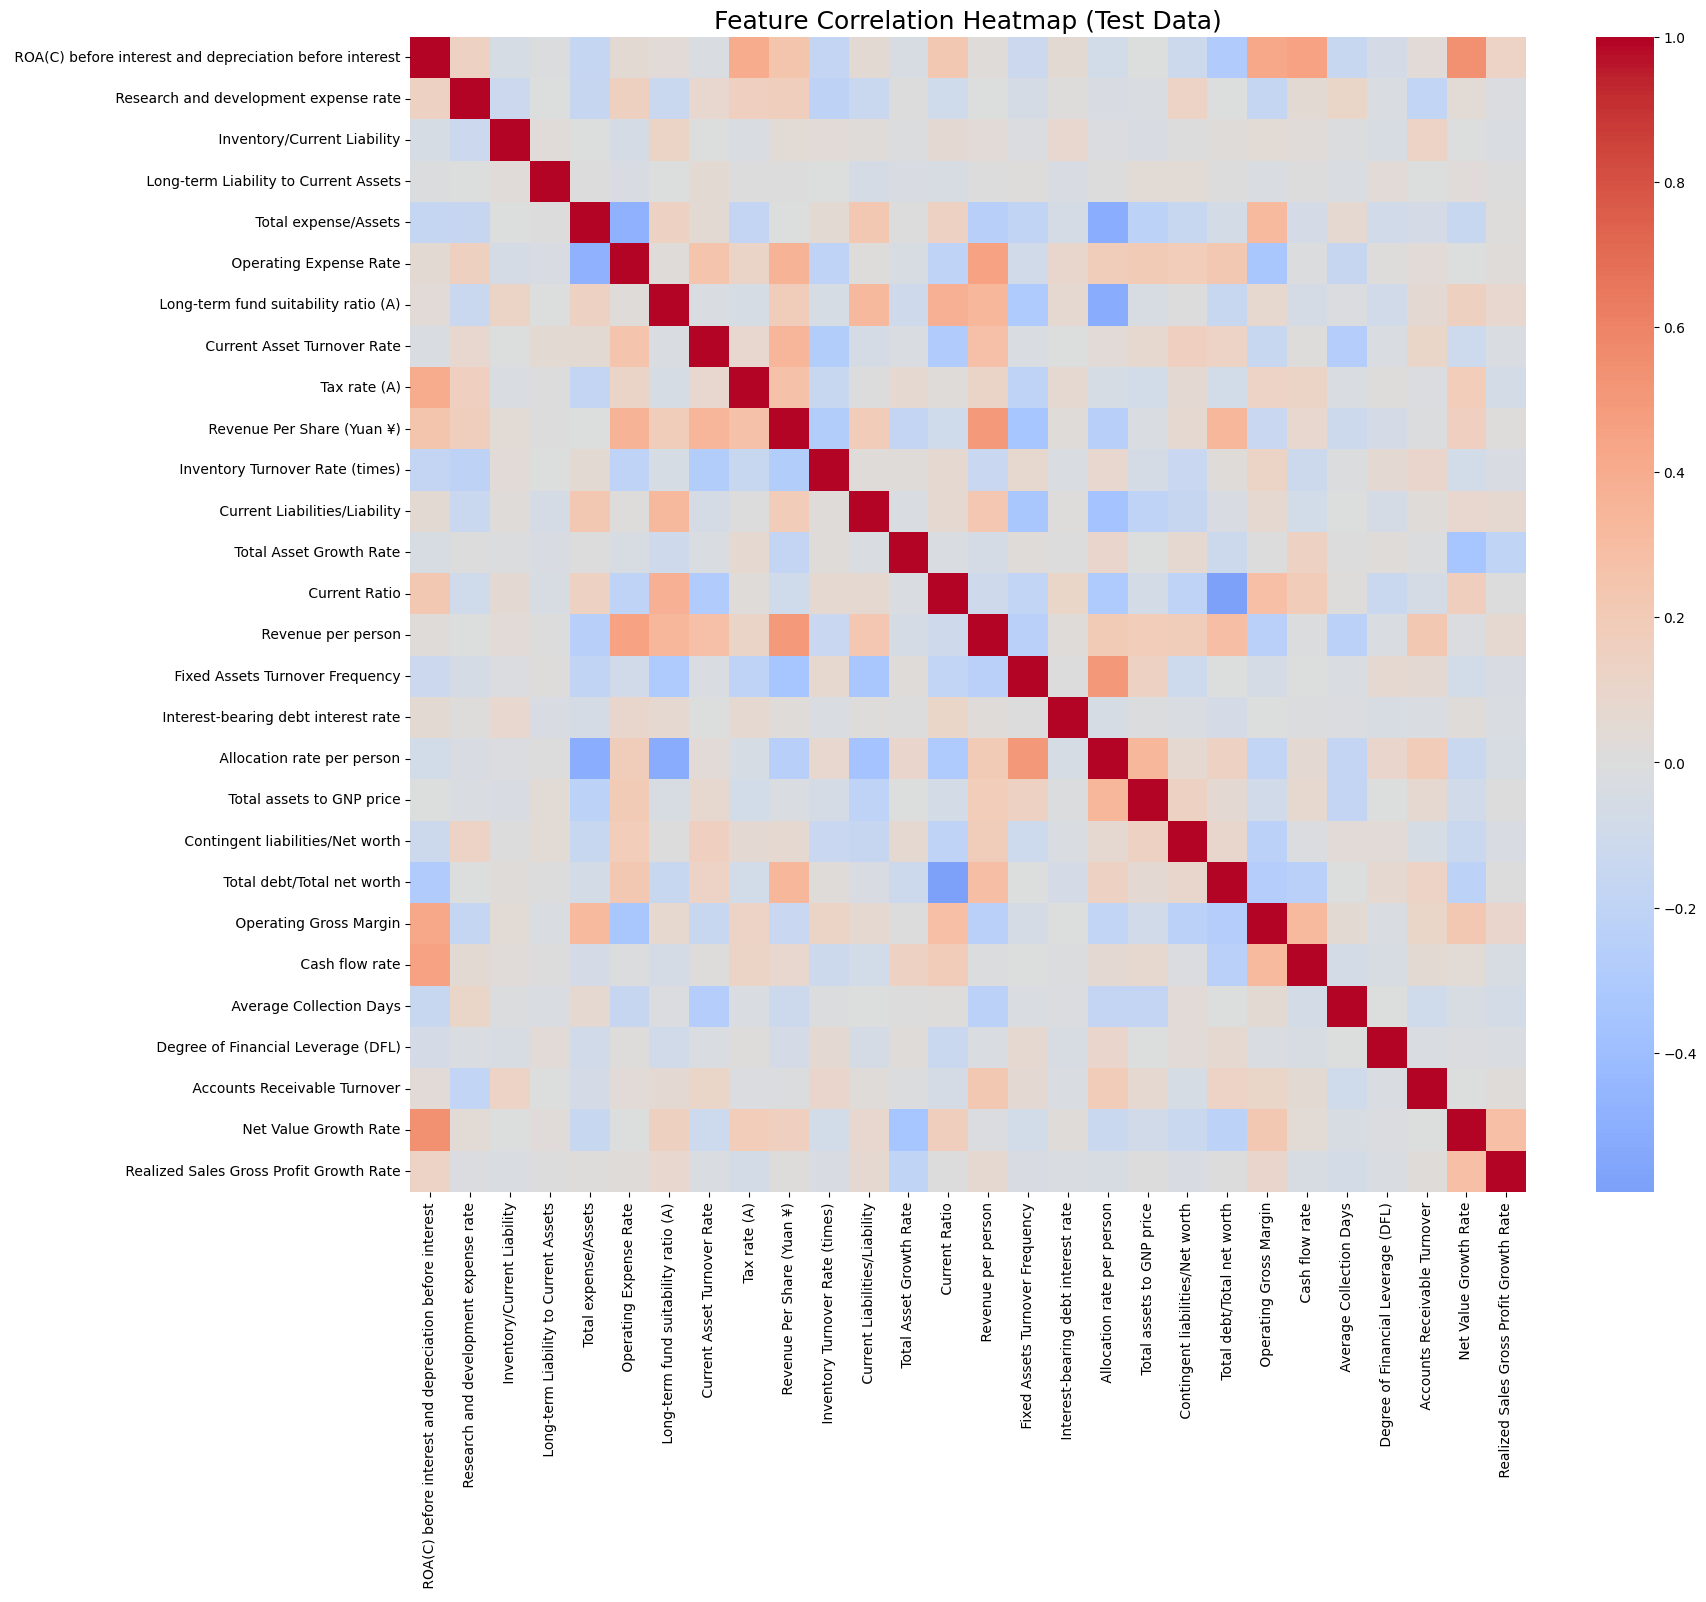

In [59]:
print("Generating correlation heatmap of test data...")
plt.figure(figsize=(18, 15))
sns.heatmap(X_test_final.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap (Test Data)', fontsize=18)
plt.show()


# Cluster Classifier

Loading saved cluster classifier model...
Cluster classifier model loaded.

Predicting cluster IDs for test companies...
Cluster IDs predicted.

Visualizing cluster ID distribution...


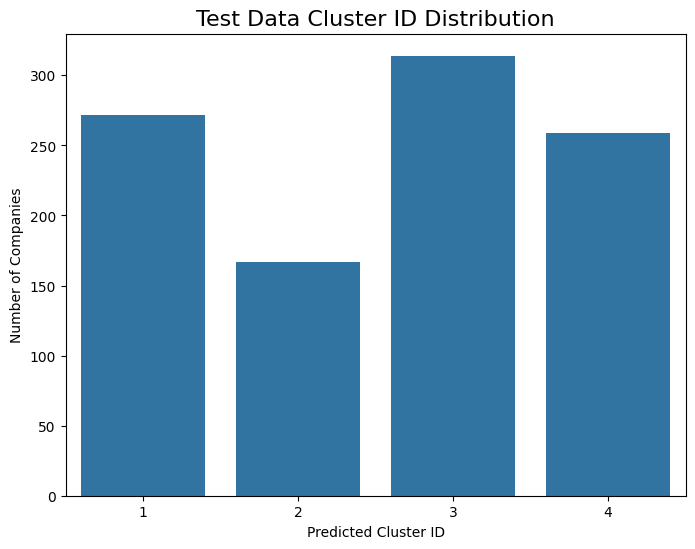


Cluster composition (Test Data):


,total
cluster,
1,272
2,167
3,314
4,259


Visualizing clusters in 2D space...


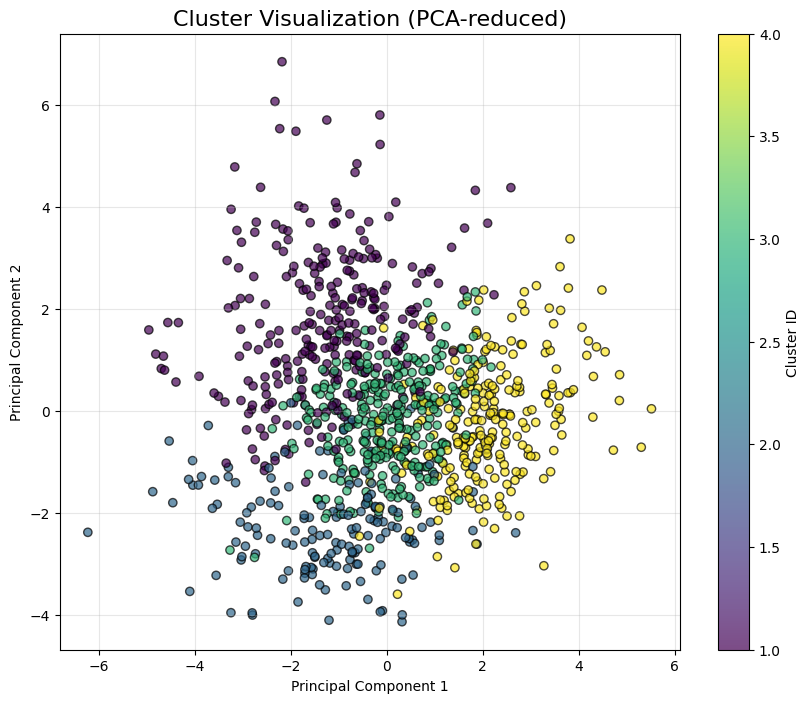

In [60]:
# --- Load Cluster Classifier ---
print("Loading saved cluster classifier model...")
cluster_classifier = joblib.load('cluster_classifier_rf.joblib')
print("Cluster classifier model loaded.\n")

# -- Ensure train and test features are in same order ---
expected_features = cluster_classifier.feature_names_in_
X_test_final_ordered = X_test_final[expected_features]

# --- Predict Cluster IDs ---
print("Predicting cluster IDs for test companies...")
test_clusters = cluster_classifier.predict(X_test_final_ordered)
print("Cluster IDs predicted.\n")


# Create "Cluster" column with Cluster IDs for all test datapoints
X_test_final["Cluster"] = test_clusters

#add Index column back
X_test_final["Index"] = test_index

# --- Cluster ID Distribution ---
print("Visualizing cluster ID distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x=test_clusters)
plt.title('Test Data Cluster ID Distribution', fontsize=16)
plt.xlabel('Predicted Cluster ID')
plt.ylabel('Number of Companies')
plt.show()

# --- Print Cluster Summary Table ---
cluster_df = pd.DataFrame({
    "cluster": test_clusters
})

# Summarize just the total number of companies per cluster
summary = (
    cluster_df
    .groupby("cluster")
    .size()                    
    .to_frame(name="total")     
    .sort_index()
)

# --- Display
print("\nCluster composition (Test Data):")
display(summary)

# --- Scatter Plot Visualization ---
print("Visualizing clusters in 2D space...")
plt.figure(figsize=(10, 8))

# Reduce to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_final_ordered)

# Create scatter plot colored by cluster
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=test_clusters, 
                     cmap='viridis', alpha=0.7, edgecolor='k')

plt.title('Cluster Visualization (PCA-reduced)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

# --- Print Cluster Summary Table ---
cluster_df = pd.DataFrame({
    "cluster": test_clusters
})

# Summarize just the total number of companies per cluster
summary = (
    cluster_df
    .groupby("cluster")
    .size()                    
    .to_frame(name="total")     
    .sort_index()
)


In [61]:
X_test_final.head()

,ROA(C) before interest and depreciation before interest,Research and development expense rate,Inventory/Current Liability,Long-term Liability to Current Assets,Total expense/Assets,Operating Expense Rate,Long-term fund suitability ratio (A),Current Asset Turnover Rate,Tax rate (A),Revenue Per Share (Yuan ¥),...,Total debt/Total net worth,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Index
0,-1.459946,-1.125416,0.912864,-0.236364,1.662563,-0.703378,-0.176836,-0.466866,-1.047772,-0.716850,...,-0.941278,0.091600,-0.844495,0.419707,-0.104267,-0.227334,-0.724296,-0.095799,4,0
1,-0.165694,-1.125428,-0.296419,1.701984,-0.437938,-0.703425,-0.712934,2.140879,0.980754,-0.509507,...,1.079342,0.181454,0.753310,-0.811542,-0.022674,2.204948,-2.459264,-0.064827,2,1
2,-0.095537,1.049487,-0.230439,-0.243814,0.017907,-0.703425,0.057692,-0.466889,-1.047772,-0.911940,...,-0.861100,-0.170333,0.368231,-0.023698,-0.087786,-0.182709,-0.303738,-0.015508,4,2
3,1.231890,0.705075,-0.225400,0.015093,-0.450678,1.422080,1.018201,2.142527,0.607887,2.003014,...,-0.000242,-0.606041,0.252749,-0.285763,-0.086782,-0.124430,0.222919,-0.024956,1,3
4,-1.753887,-1.125428,-0.198821,-0.096034,1.340532,-0.703393,-0.722386,-0.466951,-1.047772,-0.420092,...,-0.015192,-0.633408,-0.442563,0.071119,-0.152320,-0.195731,-1.240521,-0.080510,3,4


# CLUSTER 1 MODEL - SWATHI 



Cluster 1 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,271,99.63
Predicted Bankrupt,1,0.37


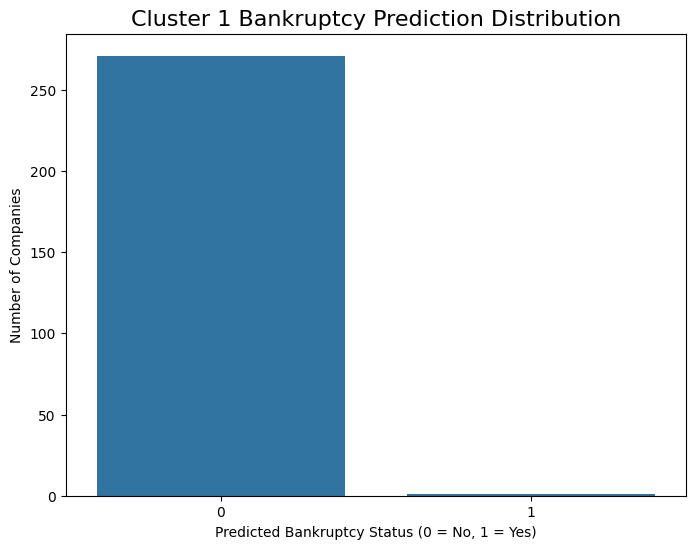

In [62]:

df_cl1 = X_test_final[X_test_final["Cluster"]==1]

# Save Indexes to attach back later
cl1_indexes = df_cl1["Index"]

# function to further process test data for cluster 1 model
def process_data_cl1(df):
    X_selected = df[[' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Revenue per person', ' Total debt/Total net worth']]
    return X_selected
        

X_selected1 = process_data_cl1(df_cl1)

# -- Load in model ------
model =joblib.load('cluster1_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 1 df
cl1_predictions = []
for i, row in X_selected1.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl1_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected df ----
X_selected1["Prediction"] = cl1_predictions
X_selected1["Index"] = cl1_indexes
X_selected1.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected1["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 1 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl1_predictions)
plt.title('Cluster 1 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

In [63]:
X_selected1.head()


,Total expense/Assets,Revenue Per Share (Yuan ¥),Revenue per person,Total debt/Total net worth,Prediction,Index
3,-0.450678,2.003014,1.717115,-0.000242,0,3
5,0.155438,-1.252895,2.427579,0.503182,0,5
6,-0.957903,0.171527,-0.228101,0.019086,0,6
10,-1.069772,-0.230091,2.245138,-0.444654,0,10
14,-1.665019,0.340375,1.547663,0.795135,0,14


# CLUSTER 2 MODEL - SHREEL (SIMPLIFIED VERSION)


,count,percentage
Prediction,,
Healthy,165,98.8
Predicted Bankrupt,2,1.2


Text(0.5, 0, '(0 = Healthy, 1 = Bankrupt)')

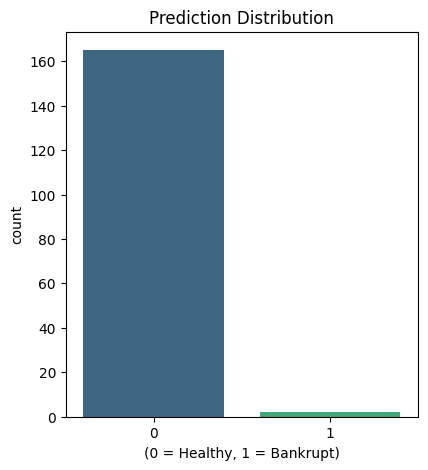

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Data Preparation ---
df_cl2 = X_test_final[X_test_final["Cluster"] == 2].copy()
cl2_indexes = df_cl2["Index"]

# Select only the top 3 features
X_test = df_cl2[[
    ' Total debt/Total net worth',
    ' Cash flow rate', 
    ' Operating Gross Margin'
]].copy()

# --- Preprocessing ---
def safe_preprocessing(X, scaler=None):
    """Safe preprocessing pipeline with outlier clipping"""
    X_clean = X.replace([np.inf, -np.inf], np.nan).copy()
    X_clean.fillna(X_clean.mean(), inplace=True)
    
    # Robust outlier clipping (1st/99th percentiles)
    for col in X_clean.columns:
        q1 = X_clean[col].quantile(0.01)
        q99 = X_clean[col].quantile(0.99)
        X_clean[col] = np.clip(X_clean[col], q1, q99)
    
    # Standard Scaling
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
    else:
        X_scaled = scaler.transform(X_clean)
    
    return X_scaled, scaler

# Load or create scaler
try:
    scaler = joblib.load('cluster2_scaler.joblib')
    X_test_scaled = scaler.transform(X_test)
except:
    X_test_scaled, scaler = safe_preprocessing(X_test)
    joblib.dump(scaler, 'cluster2_scaler.joblib')

# --- Model Prediction ---
model = joblib.load('cluster2_stacking_model.joblib') 
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

# --- Create Results DataFrame ---
results_df = pd.DataFrame({
    'Index': cl2_indexes.values,
    'Prediction': predictions,
  
})

# --- Analysis Report ---
summary = (
    results_df["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)
display(summary)
# --- Prediction Distribution ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=predictions, palette='viridis')
plt.title('Prediction Distribution')
plt.xlabel('(0 = Healthy, 1 = Bankrupt)')



# --- Feature Importance Analysis ---

# CLUSTER 3 MODEL - Jack 



Cluster 3 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,313,99.68
Predicted Bankrupt,1,0.32


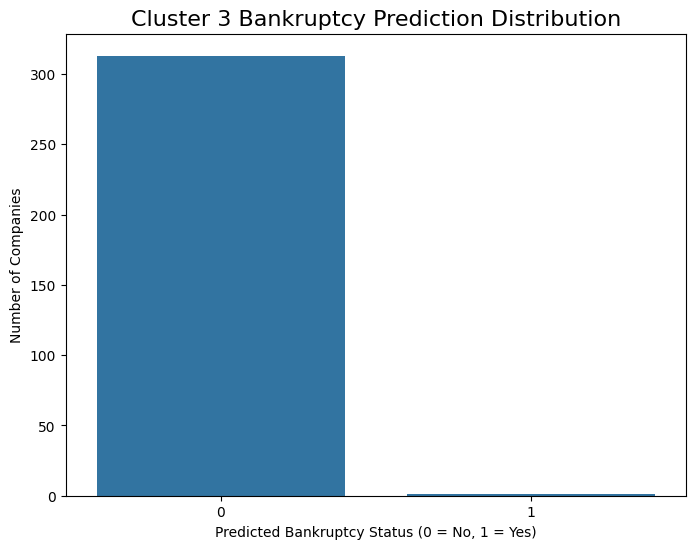

In [65]:

df_cl3 = X_test_final[X_test_final["Cluster"]==3]

# Save Indexes to attach back later
cl3_indexes = df_cl3["Index"]

# function to further process test data for cluster 1 model
def process_data_cl3(df):
    X_selected = df[[" Total expense/Assets", " Revenue Per Share (Yuan ¥)", 
                   " Current Liabilities/Liability", " Total debt/Total net worth", 
                   " Degree of Financial Leverage (DFL)"]]
    return X_selected
        

X_selected3 = process_data_cl3(df_cl3)

# -- Load in model ------
model =joblib.load('cluster3_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 1 df
cl3_predictions = []
for i, row in X_selected3.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl3_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected df ----
X_selected3["Prediction"] = cl3_predictions
X_selected3["Index"] = cl3_indexes
X_selected3.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected3["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 3 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl3_predictions)
plt.title('Cluster 3 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

# CLUSTER 4 MODEL - KHUSHI



Cluster 4 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,187,72.2
Predicted Bankrupt,72,27.8


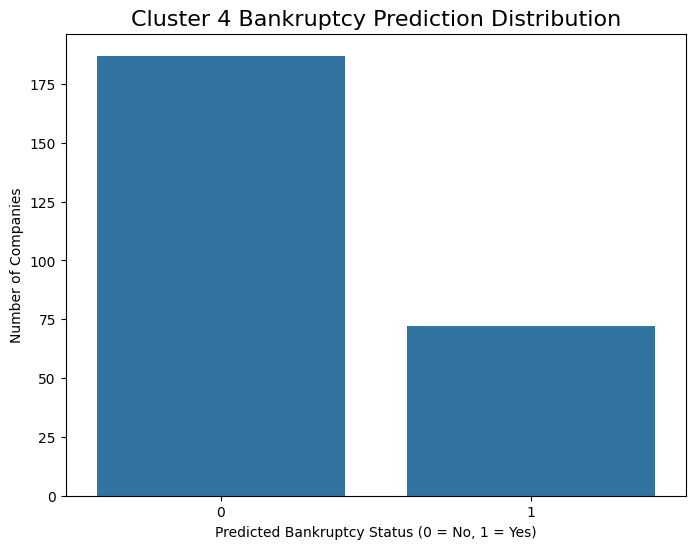

In [66]:

df_cl4 = X_test_final[X_test_final["Cluster"]==4]

# Save Indexes to attach back later
cl4_indexes = df_cl4["Index"]

# function to further process test data for cluster 3 model
def process_data_cl4(df):
    X_selected = df[[' Net Value Growth Rate', ' Total expense/Assets', ' ROA(C) before interest and depreciation before interest', ' Degree of Financial Leverage (DFL)', ' Total debt/Total net worth']]
    return X_selected
        

X_selected4 = process_data_cl4(df_cl4)

# -- Load in model ------
model = joblib.load('cluster4_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 3 df
cl4_predictions = []
for i, row in X_selected4.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl4_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected3 df ----
X_selected4["Prediction"] = cl4_predictions
X_selected4["Index"] = cl4_indexes
X_selected4.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected4["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 4 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl4_predictions)
plt.title('Cluster 4 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

# MERGE ALL CLUSTER PREDICTIONS WITH ORIGINAL TEST DATA


In [67]:

# add back test indices to X_test_final
X_test_final["Index"] = test_index

# 1) Include cluster2 in the concat
all_predictions = pd.concat([
    X_selected1[["Index", "Prediction"]],
    results_df[["Index", "Prediction"]],   # ← add this line
    X_selected3[["Index", "Prediction"]],
    X_selected4[["Index", "Prediction"]]
])

X_test_final_with_predictions = X_test_final.merge(
    all_predictions, on="Index", how="left"
)

table2 = X_test_final_with_predictions[["Index", "Prediction"]]
table2.rename(columns={"Prediction": "Bankrupt?"}, inplace=True)

# Uncomment to force ints:
table2["Bankrupt?"] = table2["Bankrupt?"] \
    .fillna(0) \
    .astype(int)


print(table2.head())

# 2) Suppress the auto‐generated row index by using index=False
table2.to_csv("Group4_Generalization.csv", index=False)


   Index  Bankrupt?
0      0          1
1      1          0
2      2          0
3      3          0
4      4          0
